# Kaggle's Titanic Starter Competition: 2nd attempt

A first attempt at Kaggle's [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) I got up to 73% accuracy by doing some preprocessing, training with scikit-learn models and submitting.

From [reading around](https://www.quora.com/How-does-one-solve-the-titanic-problem-in-Kaggle) (but not peeking!) it seems that it should be possible to get closer to 80%, and many suspect that those who score much higher are cheating and looking at the full dataset.

So my goal for this follow up notebook is to dig a bit deeper and get above 77% accuracy.

## Candidates for improvement

Some ways I could improve on the first attempt:
- Explore the data to get better intuition
- Include more previously skipped variables
  - Cabin: we could group these by main cabin location (e.g A, B, C, D) in case general location had some influence on e.g how fast folks could get to the life boats.
  - Embarked: could include this in case where people departed from is correlated in some way with survivorship; perhaps those from one location were close knit and had an in on the surival boats? 
- Hyperparameter tuning: we could experiment with some of the available parameters for each model to see if we get better performance against our 30% test set, for instance tree-depth, and regularization parameter C for logistic regression and SVMs

In the first notebook, the fancier models, non-linear SVM and random forests, performed no better than logistic regression. One of the benefits of random forest classifier models is that they don't require much tuning; the randomization step of the ensemble of decision trees each looking at different portions of the variables and training samples provides some automatic tuning. As Python Machine Learning puts it, "We typically don't need to prune the random forest since the ensemble model is quite robust to noise from the individual decision trees."

So if a robust non-linear model performs no better than an untuned logistic regression model, my sense is that fussing with hyperparameter tuning won't get us very far looking at the same variables of the dataset. I think the next best step is to look more closely at the parameters via exploratory analysis and see if it's worth adding in 'Cabin' and/or 'Embarked' and perhaps whether some other parameters could be ignored completely.

## Exploring variables

The first step in exploring the variables of the dataset is to look at each individaully to see what their distributions look like. 


```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```

In [1]:
import pandas as pd

training_data = pd.read_csv('train.csv')

training_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


The dependent variable "surivived" is categorical. Let's do some C->C and Q->C analysis on the categorical output variable, 'survived'.

### Side by side bar charts for categorical features 

For C->C analysis I like side by side bar charts. Let's look at "Pclass", "Sex", and "Embarked". For good measure, we'll intepret the first letter of "Cabin" as another categorical variable.


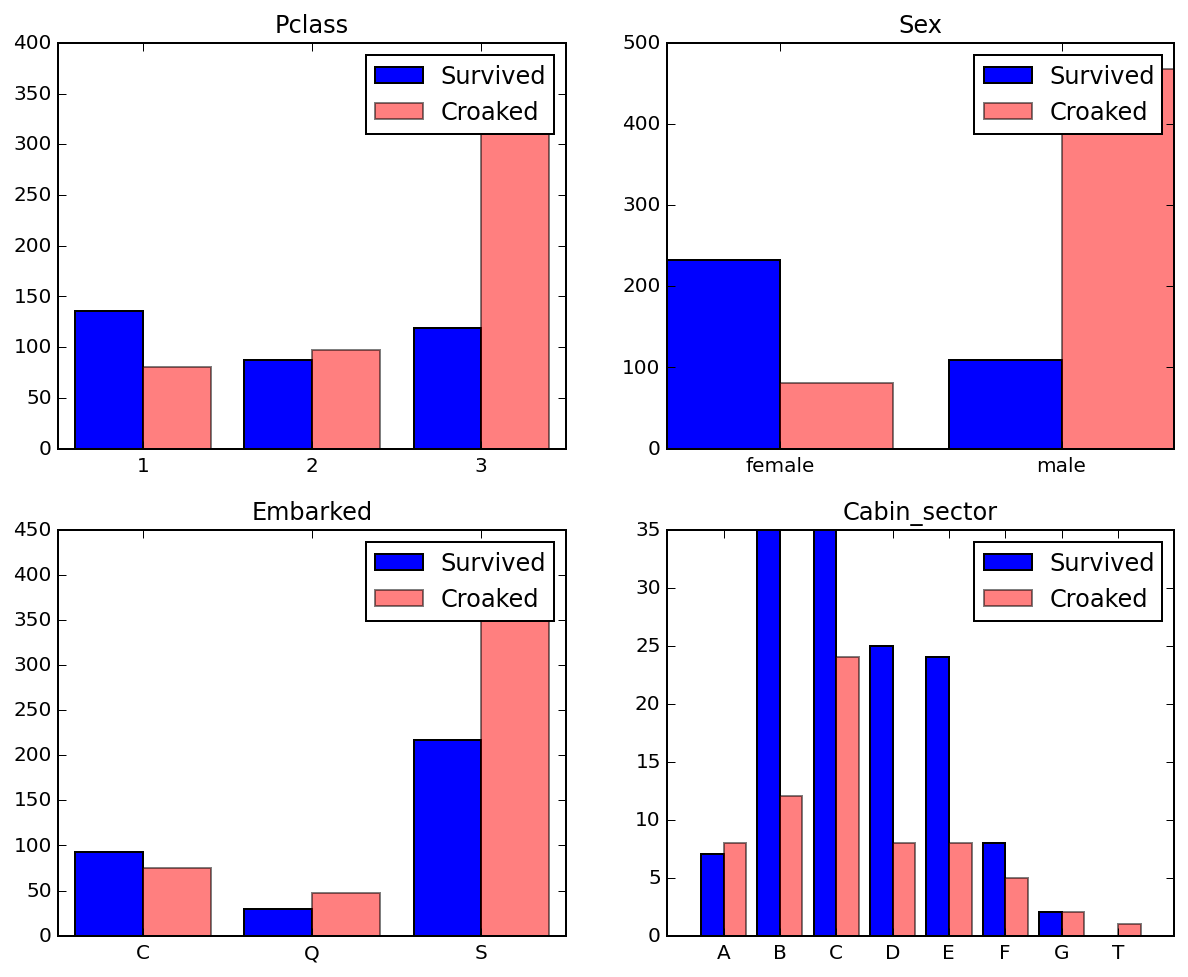

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

td = training_data.copy()
td[['Cabin_sector']] = td[['Cabin']].dropna().applymap(lambda cabin: cabin[0])

def num_survived(var, val):
    return td[var][(td['Survived'] == 1) & (td[var] == val)].count()

def num_croaked(var, val):
    return td[var][(td['Survived'] == 0) & (td[var] == val)].count()

cvars = ['Pclass', 'Sex', 'Embarked', 'Cabin_sector']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

bar_width = 0.4

for i, cvar in enumerate(cvars):
    row = i // 2
    col = i % 2
    subplot = ax[row, col]
    
    all_labels = td[cvar].dropna().unique()
    all_labels.sort()
    bar_locations = np.arange(len(all_labels))
    subplot.bar(
        bar_locations - bar_width,
        [num_survived(cvar, label) for label in all_labels],
        bar_width,
        color='b'
    )
    subplot.bar(
        bar_locations,
        [num_croaked(cvar, label) for label in all_labels],
        bar_width,
        color='r',
        alpha=0.5
    )
    subplot.set_title(cvar)
    subplot.legend(('Survived', 'Croaked'))
    subplot.set_xticks(bar_locations)
    subplot.set_xticklabels(all_labels)    


The variables we used last time, Sex and Pclass both look to have some correlation with surviving, and likely play a role in the success the model had so far in predicting (particularly sex).

It also appears that where the passenger embarked from and what cabin sector also have some correlation with surviving:
- those who depart from Southampton croak disproportionately 
- those who stayed in cabin sectors b, c, d and e survived disproportionately

So this is promising! Adding in 'Embarked' and 'Cabin_sector' should improve the model.


### Histograms for quantitative features

For Q->C analysis I like overlapping histograms as it gives an idea of . The quantitative variables we'll look at are "Age", "SibSp", "Parch"  and "Fare", and we're plotting each segmented by survivorship, so, for instance, the "Q->C" is "Age->Survived".


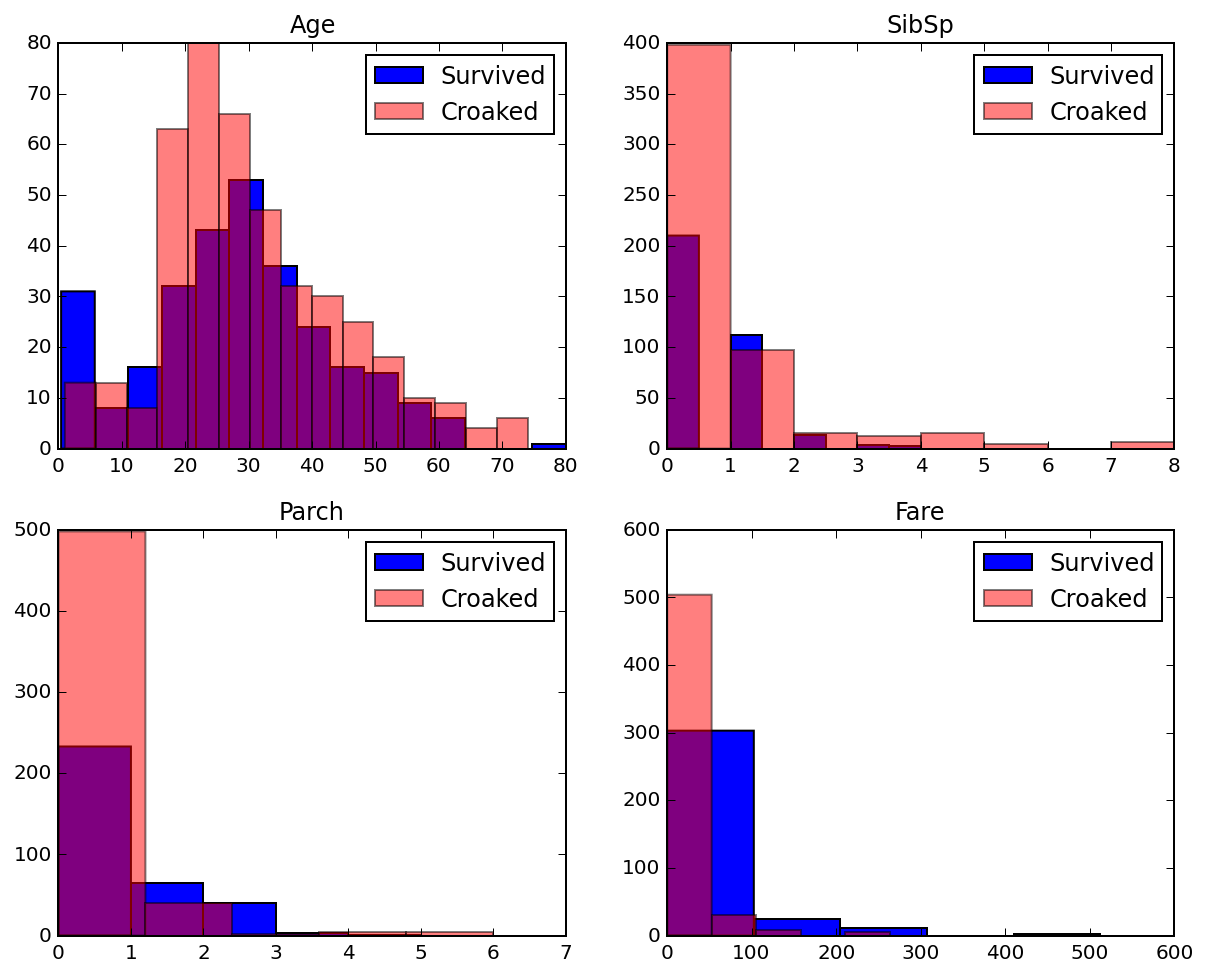

In [3]:
survived = td[td['Survived'] == 1]
croaked = td[td['Survived'] == 0]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, (var, bins) in enumerate([("Age", 15), ("SibSp", 8), ("Parch", 5), ("Fare", 5)]):
    row = i // 2
    col = i % 2
    subplot = ax[row, col]
    subplot.set_title(var)

    # side by side
#     subplot.hist(
#         [survived[var].dropna().values, croaked[var].dropna().values], 
#         bins=bins, label=['Survived', 'Croaked'])

    # overlapping
    subplot.hist(survived[var].dropna().values, bins=bins, color='b', label='Survived')
    subplot.hist(croaked[var].dropna().values, bins=bins, color='r', alpha=0.5, label='Croaked')
    subplot.legend()
None

I notice:
- Young children survive disproportionately
- There may be a correlation between fare and survivorship; those who pay more than the lowest value seem to survive disproportionately
- Those with no family aboard (either childeren via 'Parch' or siblings via 'SibSp') perish disproprotinately

So each of these variables seems worth keeping in our model.

## Re-testing models against richer data

Now that I'm confident adding in the previously skipped variables 'Embarked' and the computed 'Cabin_Sector" could help, I think a good plan is to re-run the same models we tried last time is worth a shot. Here's the updated preprocessor helper function we'll use. Updates since last time:
- We include 'Embarked' and 'Cabin_sector' 
- Since both multiple non-ordinal values, we'll use one-hot encoding to flatten them out into one binary variable for each possible value, e.g embarked becomes embarked_from_C, embarked_from_Q, embarked_from_S
- We can handle missing values by setting the flattened out variable values to 0

In [4]:
# %load titanic.py
from sklearn.preprocessing import StandardScaler
import pandas as pd

def make_preprocesser(training_data):
    """
    Constructs a preprocessing function ready to apply to new dataframes.

    Crucially, the interpolating that is done based on the training data set
    is remembered so it can be applied to test datasets (e.g the mean age that
    is used to fill in missing values for 'Age' will be fixed based on the mean
    age within the training data set).

    Summary by column:

    ['PassengerId',
     'Survived',    # this is our target, not a feature
     'Pclass',      # keep as is: ordinal value should work, even though it's inverted (higher number is lower class cabin)
     'Name',        # omit (could try some fancy stuff like inferring ethnicity, but skip for now)
     'Sex',         # code to 0 / 1
     'Age',         # replace missing with median
     'SibSp',
     'Parch',
     'Ticket',      # omit (doesn't seem like low hanging fruit, could look more closely for pattern later)
     'Fare',        # keep, as fare could be finer grained proxy for socio economic status, sense of entitlement / power in getting on boat
     'Cabin',       # one hot encode using first letter as cabin as the cabin sector
     'Embarked']    # one hot encode

    Params:
        df: pandas.DataFrame containing the training data
    Returns:
        fn: a function to preprocess a dataframe (either before training or fitting a new dataset)
    """

    def pick_features(df):
        return df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]

    # save median Age so we can use it to fill in missing data consistently
    # on any dataset
    median_age_series = training_data[['Age', 'Fare']].median()

    def fix_missing(df):
        return df.fillna(median_age_series)

    def map_sex(df):
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
        return df

    def one_hot_cabin(df):
        def cabin_sector(cabin):
            if isinstance(cabin, str):
                return cabin[0].lower()
            else:
                return cabin

        df[['cabin_sector']] = df[['Cabin']].applymap(cabin_sector)
        one_hot = pd.get_dummies(df['cabin_sector'], prefix="cabin_sector")

        interesting_cabin_sectors = ["cabin_sector_{}".format(l) for l in 'bcde']

        for column, _ in one_hot.iteritems():
            if column.startswith('cabin_sector_') and column not in interesting_cabin_sectors:
                one_hot = one_hot.drop(column, axis=1)

        df = df.join(one_hot)

        df = df.drop('Cabin', axis=1)
        df = df.drop('cabin_sector', axis=1)
        return df

    def one_hot_embarked(df):
        one_hot = pd.get_dummies(df['Embarked'], prefix="embarked")
        df = df.join(one_hot)
        df = df.drop('Embarked', axis=1)
        return df

    # We want standard scaling fit on the training data, so we get a scaler ready
    # for application now. It needs to be applied to data that already has the other
    # pre-processing applied.
    training_data_all_but_scaled = map_sex(fix_missing(pick_features(training_data)))
    stdsc = StandardScaler()
    stdsc.fit(training_data_all_but_scaled[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

    def scale_df(df):
        df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = \
            stdsc.transform(df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        df[['Sex']] = df[['Sex']].applymap(lambda x: 1 if x == 1 else -1)
        for column, _ in df.iteritems():
            if column.startswith('cabin_sector_') or column.startswith('embarked_'):
                df[[column]] = df[[column]].applymap(lambda x: 1 if x == 1 else -1)
        return df

    def preprocess(df, scale=True):
        """
        Preprocesses a dataframe so it is ready for use with a model (either for training or prediction).

        Params:
            scale: whether to apply feature scaling. E.g with random forests feature scaling isn't necessary.
        """
        all_but_scaled = one_hot_embarked(one_hot_cabin(map_sex(fix_missing(pick_features(df)))))
        if scale:
            return scale_df(all_but_scaled)
        else:
            return all_but_scaled

    return preprocess


In [5]:
preprocess = make_preprocesser(training_data)

td_preprocessed_unscaled = preprocess(training_data, scale=False)

td_preprocessed_unscaled.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_sector_b,cabin_sector_c,cabin_sector_d,cabin_sector_e,embarked_C,embarked_Q,embarked_S
0,1,3,0,22,1,0,7.2500,0,0,0,0,0,0,1
1,2,1,1,38,1,0,71.2833,0,1,0,0,1,0,0
2,3,3,1,26,0,0,7.9250,0,0,0,0,0,0,1
3,4,1,1,35,1,0,53.1000,0,1,0,0,0,0,1
4,5,3,0,35,0,0,8.0500,0,0,0,0,0,0,1


In [6]:
td_preprocessed = preprocess(training_data, scale=True)

td_preprocessed.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_sector_b,cabin_sector_c,cabin_sector_d,cabin_sector_e,embarked_C,embarked_Q,embarked_S
0,1,0.827377,-1,-0.565736,0.432793,-0.473674,-0.502445,-1,-1,-1,-1,-1,-1,1
1,2,-1.566107,1,0.663861,0.432793,-0.473674,0.786845,-1,1,-1,-1,1,-1,-1
2,3,0.827377,1,-0.258337,-0.474545,-0.473674,-0.488854,-1,-1,-1,-1,-1,-1,1
3,4,-1.566107,1,0.433312,0.432793,-0.473674,0.420730,-1,1,-1,-1,-1,-1,1
4,5,0.827377,-1,0.433312,-0.474545,-0.473674,-0.486337,-1,-1,-1,-1,-1,-1,1


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

for name, should_scale, model in [
        ("Decision Tree", False, DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)),
        ("Random forest", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=10, 
                                    random_state=1,
                                    n_jobs=2)),
        ("Logistic Regression", True, LogisticRegression(C=100.0, random_state=0)),
        ("Linear SVM", True, SVC(kernel='linear', C=1.0, random_state=0)),
        ("Kernel SVM", True, SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0))]:
    pre_processed = td_preprocessed if should_scale else td_preprocessed_unscaled
    X = pre_processed.loc[:,'Pclass':]
    y = training_data['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    model.fit(X_train, y_train)
    print("{} training/test accuracy: {:.2f} | {:.2f}".format(
            name, 
            accuracy_score(y_train, model.predict(X_train)),
            accuracy_score(y_test, model.predict(X_test))))


Decision Tree training/test accuracy: 0.84 | 0.82
Random forest training/test accuracy: 0.96 | 0.79
Logistic Regression training/test accuracy: 0.81 | 0.80
Linear SVM training/test accuracy: 0.79 | 0.78
Kernel SVM training/test accuracy: 0.88 | 0.81


Bummer that this only seems to have added a modest boost. Let's try submitting an the LGR anyways.

In [8]:
fully_trained_lgr = LogisticRegression(C=100.0, random_state=0)

X = td_preprocessed.loc[:,'Pclass':]
y = training_data['Survived']

fully_trained_lgr.fit(X, y)
print("Logistic Regression full training set accuracy: {:.2f}".format(
        accuracy_score(y, fully_trained_lgr.predict(X))))

test_data = pd.read_csv('test.csv')
test_data_preprocessed = preprocess(test_data, scale=True)
test_data_preprocessed.head()

Logistic Regression full training set accuracy: 0.81


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_sector_b,cabin_sector_c,cabin_sector_d,cabin_sector_e,embarked_C,embarked_Q,embarked_S
0,892,0.827377,-1,0.394887,-0.474545,-0.473674,-0.490783,-1,-1,-1,-1,-1,1,-1
1,893,0.827377,1,1.355510,0.432793,-0.473674,-0.507479,-1,-1,-1,-1,-1,-1,1
2,894,-0.369365,-1,2.508257,-0.474545,-0.473674,-0.453367,-1,-1,-1,-1,-1,1,-1
3,895,0.827377,-1,-0.181487,-0.474545,-0.473674,-0.474005,-1,-1,-1,-1,-1,-1,1
4,896,0.827377,1,-0.565736,0.432793,0.767630,-0.401017,-1,-1,-1,-1,-1,-1,1


In [9]:
test_data_predict = fully_trained_lgr.predict(test_data_preprocessed.loc[:,'Pclass':])

submission_df = test_data_preprocessed[['PassengerId']].copy()
submission_df['Survived'] = test_data_predict

submission_df.to_csv(
    'titanic_submission_logistic_regression_2.csv',
    index=False)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


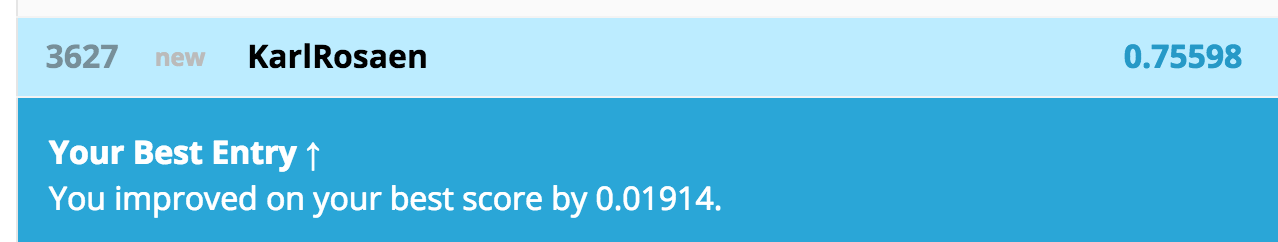

In [10]:
from IPython.display import Image
Image(filename='kaggle-submission-logistic-regression2.png', width=600)

This is just under a 2% boost from last time. *sigh*

## Beefier trees and forests

Well, let's try some different parameters for trees and forests to see how it looks

In [11]:
for name, should_scale, model in [
        ("Decision Tree depth 3", False, DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)),
        ("Decision Tree depth 6", False, DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)),
        ("Decision Tree depth 9", False, DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=0)),
        ("Decision Tree depth 12", False, DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=0)),
        ("Random forest", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=10, 
                                    random_state=1,
                                    n_jobs=2,
                                    max_features='auto')),
        ("Random forest 50 estimators", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=50, 
                                    random_state=1,
                                    n_jobs=2,
                                    max_features='auto')),
        ("Random forest 10 features", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=10, 
                                    random_state=1,
                                    n_jobs=2,
                                    max_features=10)),
        ("Random forest 10 feature 50 estimator", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=50, 
                                    random_state=1,
                                    n_jobs=2,
                                    max_features=10)),]:
    pre_processed = td_preprocessed if should_scale else td_preprocessed_unscaled
    X = pre_processed.loc[:,'Pclass':]
    y = training_data['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    model.fit(X_train, y_train)
    print("{} training/test accuracy: {:.2f} | {:.2f}".format(
            name, 
            accuracy_score(y_train, model.predict(X_train)),
            accuracy_score(y_test, model.predict(X_test))))


Decision Tree depth 3 training/test accuracy: 0.84 | 0.82
Decision Tree depth 6 training/test accuracy: 0.88 | 0.80
Decision Tree depth 9 training/test accuracy: 0.92 | 0.78
Decision Tree depth 12 training/test accuracy: 0.97 | 0.79
Random forest training/test accuracy: 0.96 | 0.79
Random forest 50 estimators training/test accuracy: 0.98 | 0.80
Random forest 10 features training/test accuracy: 0.96 | 0.81
Random forest 10 feature 50 estimator training/test accuracy: 0.98 | 0.82


Let's try submitting with the Random forest with 10 features (default is square root of the number of features which would be ~3) and 50 estimators

### Submitting beefy forest

In [12]:
fully_trained_beefy_forest = RandomForestClassifier(criterion='entropy',
                                    n_estimators=50, 
                                    random_state=1,
                                    n_jobs=2,
                                    max_features=10)

X = td_preprocessed_unscaled.loc[:,'Pclass':]
y = training_data['Survived']

fully_trained_beefy_forest.fit(X, y)
print("Beefy forest full training set accuracy: {:.2f}".format(
        accuracy_score(y, fully_trained_beefy_forest.predict(X))))

test_data_preprocessed_unscaled = preprocess(test_data, scale=False)
test_data_preprocessed_unscaled.head()

Beefy forest full training set accuracy: 0.98


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_sector_b,cabin_sector_c,cabin_sector_d,cabin_sector_e,embarked_C,embarked_Q,embarked_S
0,892,3,0,34.5,0,0,7.8292,0,0,0,0,0,1,0
1,893,3,1,47.0,1,0,7.0000,0,0,0,0,0,0,1
2,894,2,0,62.0,0,0,9.6875,0,0,0,0,0,1,0
3,895,3,0,27.0,0,0,8.6625,0,0,0,0,0,0,1
4,896,3,1,22.0,1,1,12.2875,0,0,0,0,0,0,1


In [13]:
test_data_predict = fully_trained_beefy_forest.predict(test_data_preprocessed_unscaled.loc[:,'Pclass':])

submission_df = test_data_preprocessed[['PassengerId']].copy()
submission_df['Survived'] = test_data_predict

submission_df.to_csv(
    'titanic_submission_decision_tree_2.csv',
    index=False)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


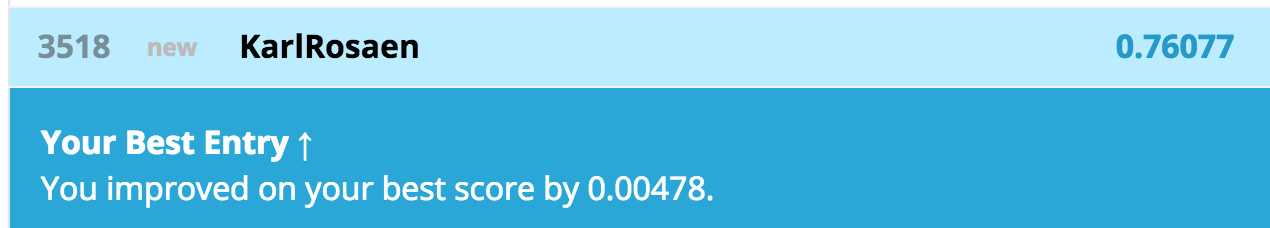

In [14]:
Image(filename='kaggle-submission-random-forest2.png', width=600)

### Submitting various tree depths

In [15]:
for depth in [3, 6, 9]:
    print("preparing tree of depth {} for submission".format(depth))
    deep_tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    X = td_preprocessed_unscaled.loc[:,'Pclass':]
    y = training_data['Survived']
    deep_tree.fit(X, y)
    print("deep_tree depth {} full training set accuracy: {:.2f}".format(
            depth,
            accuracy_score(y, deep_tree.predict(X))))
    test_data_predict = deep_tree.predict(test_data_preprocessed_unscaled.loc[:,'Pclass':])

    submission_df = test_data_preprocessed[['PassengerId']].copy()
    submission_df['Survived'] = test_data_predict

    submission_df.to_csv(
        'titanic_submission_decision_tree_depth{}.csv'.format(depth),
        index=False)
    

preparing tree of depth 3 for submission
deep_tree depth 3 full training set accuracy: 0.82
preparing tree of depth 6 for submission
deep_tree depth 6 full training set accuracy: 0.86
preparing tree of depth 9 for submission
deep_tree depth 9 full training set accuracy: 0.90


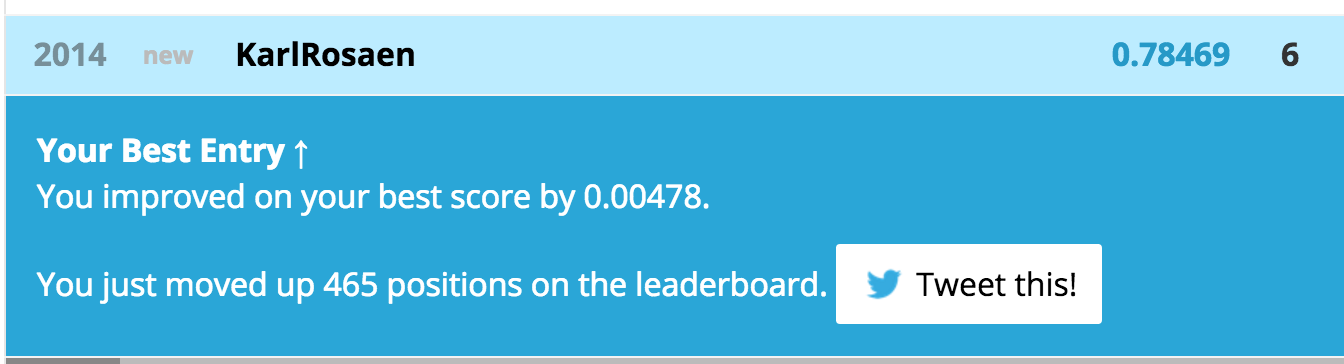

In [16]:
Image(filename='kaggle-submission-tree-depth3.png', width=600)

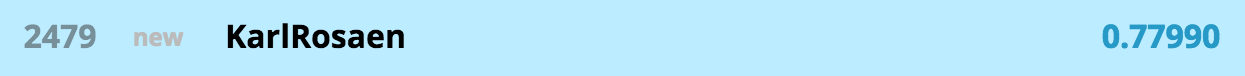

In [17]:
Image(filename='kaggle-submission-tree-depth6.png', width=600)

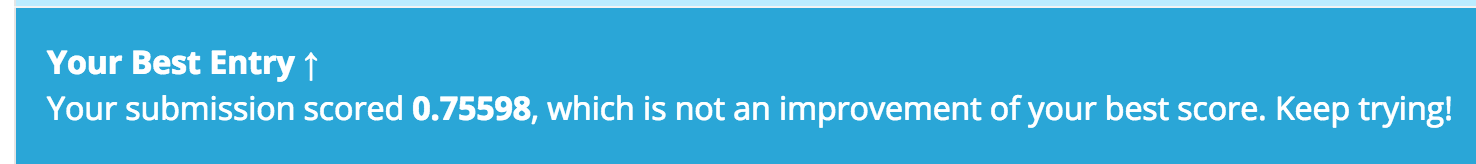

In [18]:
Image(filename='kaggle-submission-tree-depth9.png', width=600)

## Reaching my goal with tree depth 3

Interesting, so the performance on the local test dataset was pretty spot on for how well it generalizes to the unseen kaggle test set: the tree depth of 3 performed best on kaggle. For some reason the plain tree does better than a random forest in this case even though they looked like they'd perform about the same.

In any case, my tree depth 3 trained against all of the features has reached a 78% accuracy, meeting my goal!

### So would tree depth 3 work skipping the variables like we did in our first attempt?

Let's find out.

In [19]:
tree3 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
to_drop = [col for col, _ in td_preprocessed_unscaled.iteritems() if col.startswith('cabin_sector') or col.startswith('embarked')]

X_orig = td_preprocessed_unscaled.drop(to_drop, axis=1).loc[:,'Pclass':]

X_orig.head()



,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,22,1,0,7.2500
1,1,1,38,1,0,71.2833
2,3,1,26,0,0,7.9250
3,1,1,35,1,0,53.1000
4,3,0,35,0,0,8.0500


In [20]:
y = training_data['Survived']
tree3.fit(X_orig, y)
print("deep_tree depth 3 full training set accuracy: {:.2f}".format(
        accuracy_score(y, tree3.predict(X_orig))))
test_data_predict = tree3.predict(test_data_preprocessed_unscaled.drop(to_drop, axis=1).loc[:,'Pclass':])

submission_df = test_data_preprocessed[['PassengerId']].copy()
submission_df['Survived'] = test_data_predict

submission_df.to_csv(
    'titanic_submission_decision_tree_depth3_orig.csv'.format(depth),
    index=False)

deep_tree depth 3 full training set accuracy: 0.82


Diffing the file locally, it is the same as with the full feature set.

So, yep, all the work above exploring features and reasoning that the cabin sector and departure terminal was for naught, the real fix was to submit using a decision tree!

Nonetheless, using the additional features *did* help with the logistic regression model, and it didn't hurt the decision tree.